In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

# Stein Variational Gradient Descent (SVGD)

![blobs](svgd_gaussian_blobs.gif) ![blobs](svgd_swissroll.gif)

We implement the algorithm 1 of the paper *Stein Variational Gradient Descent: A General Purpose Bayesian Inference Algorithm* (Liu and Wang, 2016). Here's the setting: Given we know the score function $x \mapsto \nabla\log p(x)$ of some probability density $p$, we want to generate a set of representative particles to approximate the density.

In [2]:
def svgd(kernel, scorefn, x_init, num_iterations,
         step_size=1e-2, cb=lambda x: None, every=10):
    """Stein Variational Gradient Descent."""

    @jax.jit
    def step(x):
        phi = lambda xi: jnp.mean(
            jax.vmap(lambda xj: kernel(xi, xj)*scorefn(xj) + jax.grad(kernel)(xj, xi))(x),
            axis=0
        )
        x = x + step_size * jax.vmap(phi)(x)
        return x
    
    x = x_init
    for i in range(num_iterations):
        x = step(x)
        if i % every == 0: 
            cb(x)
            
    return x

## Example 1: Gaussian mixture

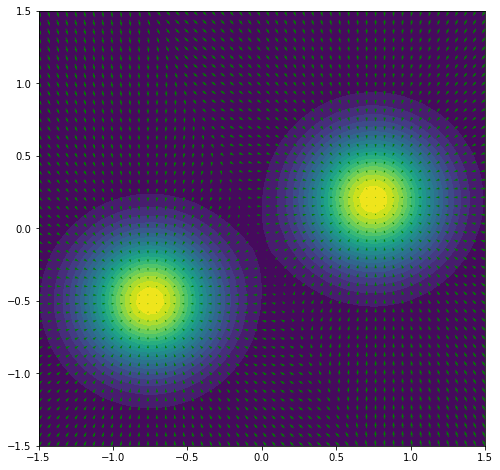

In [3]:
def RBF(lengthscale=1.0):
    return lambda x1, x2: jnp.exp(-0.5*jnp.sum((x1-x2)**2) / lengthscale**2)
    
def KDE(kernel, x):
    return lambda xi: jnp.mean(jax.vmap(kernel, (None,0))(xi, x))

def plot_contours_and_scores(p):
    scorefn = jax.grad(lambda x: jnp.log(p(x)))
    plt.figure(figsize=[8, 8])
    x1 = jnp.linspace(-1.5, 1.5, 50)
    x2 = jnp.linspace(-1.5, 1.5, 50)
    x = jnp.stack(jnp.meshgrid(x1, x2), axis=-1).reshape(-1, 2)
    scores = jax.vmap(scorefn)(x)
    scores_norm = jnp.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
    scores_log1p = scores / (scores_norm + 1e-9) * jnp.log1p(scores_norm)
    plt.contourf(x1, x2, jax.vmap(p)(x).reshape(50, 50), levels=20)
    plt.quiver(*x.T, *scores_log1p.T, width=0.002, color='green')
    
def make_gaussian_mixture(lengthscale):
    centers = jnp.array([[-0.75, -0.5], [0.75, 0.2]])
    kde = KDE(RBF(lengthscale), centers)
    scorefn = jax.grad(lambda x: jnp.log(kde(x)))
    return kde, scorefn

kde_gaussians, scorefn_gaussians = make_gaussian_mixture(lengthscale=0.3)
plot_contours_and_scores(kde_gaussians)

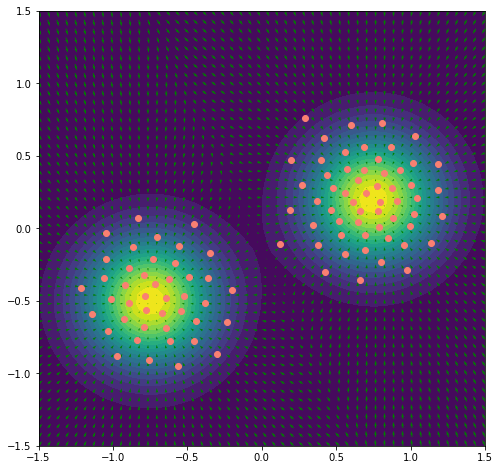

In [4]:
def callback(x):
    clear_output(True)
    plot_contours_and_scores(kde_gaussians)
    plt.scatter(*x.T, color="salmon")
    plt.xlim(-1.5,1.5)
    plt.ylim(-1.5,1.5)
    plt.show()

num_particles = 100
x_init = jax.random.normal(jax.random.PRNGKey(0), (num_particles, 2)) / 2.0
x_opt = svgd(RBF(0.1), scorefn_gaussians, x_init, num_iterations=100, step_size=0.1, cb=callback)

### Make a gif

In [5]:
import gif

frames = []

@gif.frame
def plot(x):
    clear_output(True)
    plot_contours_and_scores(kde_gaussians)
    plt.scatter(*x.T, color="salmon")
    plt.xlim(-1.5,1.5)
    plt.ylim(-1.5,1.5)
    plt.axis('off')
    plt.title("SVGD")
    
def callback(x):
    frame = plot(x)
    frames.append(frame)
    
svgd(RBF(0.1), scorefn_gaussians, x_init, num_iterations=100, step_size=0.1, cb=callback, every=1)
gif.save(frames, 'svgd_gaussian_blobs.gif', duration=5, unit="s", between="startend")

## Example 2: Swiss roll

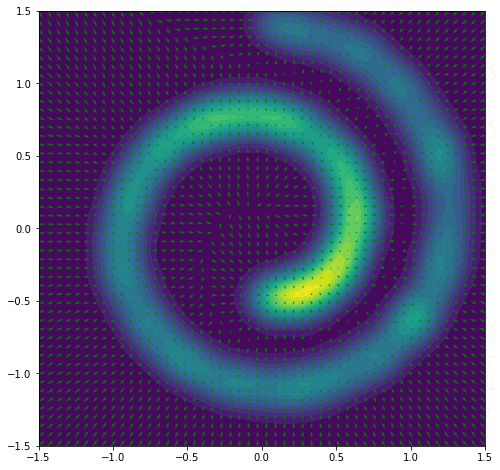

In [14]:
from sklearn.datasets import make_swiss_roll

def sample_swiss_roll(num_samples, noise=1.0):
    x, _= make_swiss_roll(num_samples, noise=noise)
    x = x[:, [0, 2]] / 10.0
    return jnp.array(x)

def make_swiss_score(num_samples=2500, lengthscale=0.1):
    x = sample_swiss_roll(num_samples=num_samples, noise=0.5)
    kde = KDE(RBF(lengthscale), x)
    scorefn = jax.grad(lambda x: jnp.log(kde(x)))
    return kde, scorefn

kde_swiss, scorefn_swiss = make_swiss_score()
plot_contours_and_scores(kde_swiss)

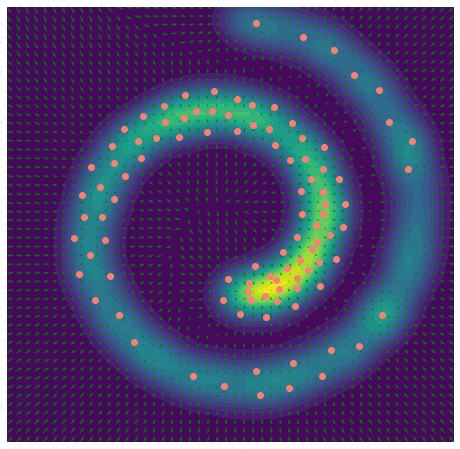

In [20]:
def callback(x):
    clear_output(True)
    plot_contours_and_scores(kde_swiss)
    plt.scatter(*x.T, color="salmon")
    plt.xlim(-1.5,1.5)
    plt.ylim(-1.5,1.5)
    plt.axis("off")
    plt.show()

x_opt = svgd(RBF(lengthscale=0.1), scorefn_swiss, x_init, num_iterations=100, step_size=0.1, cb=callback, every=5)

### Make a gif

In [11]:
import gif

frames = []

@gif.frame
def plot(x):
    clear_output(True)
    plot_contours_and_scores(kde_swiss)
    plt.scatter(*x.T, color="salmon")
    plt.xlim(-1.5,1.5)
    plt.ylim(-1.5,1.5)
    plt.axis('off')
    plt.title("SVGD")
    
def callback(x):
    frame = plot(x)
    frames.append(frame)
    
svgd(RBF(lengthscale=0.1), scorefn_swiss, x_init, num_iterations=60, step_size=5e-2, cb=callback, every=1)
gif.save(frames, 'svgd_swissroll.gif', duration=5, unit="s", between="startend")

![](svgd_swissroll.gif)